## Kill-Chain stages classification algorithm
#### Implementation and performance testing

_Note: This paper contains the implementation, as well as the results obtained by our team for the secondary purpose of KC implementation. However, the data used as set of anomalies has been previously identfied by my colleagues. I highly recommend visiting their work [here](https://github.com/Galeforse/Advanced-Cyber-Analytics-for-Attack-Detection/tree/main/Matt/2%20-%20Anomaly%20Detection), as well as downloading the obtained set of anomalies, found [here]()_

In [3]:
# install.packages(c("factoextra", "ggpubr", "dplyr", "qqman", "svMisc", "qlcMatrix"))
library(qlcMatrix)
library(ggpubr)
library(factoextra)
library(dplyr)
library(qqman)
library(svMisc)

In [2]:
setwd("D://LA//ATI Data")
df <- read.table(file="Anomalies.txt", header=T, sep=",")
df<- df[,-1]

head(df, 10)
dim(df)
str(df)

UserName,SrcDevice,DstDevice,Authent.Type,Failure,DailyCount
User341813,Comp948451,Comp915658,NetworkLogon,0,1
User341813,Comp948451,Comp915658,NetworkLogon,0,1
User341813,Comp948451,Comp915658,NetworkLogon,0,1
User341813,Comp948451,Comp915658,NetworkLogon,0,1
User341813,Comp948451,Comp915658,NetworkLogon,0,1
User341813,Comp948451,Comp915658,NetworkLogon,0,1
User341813,Comp948451,Comp915658,NetworkLogon,0,1
User341813,Comp948451,Comp915658,NetworkLogon,0,1
User341813,Comp948451,Comp004340,TGS,0,1
User341813,Comp948451,Comp004340,TGS,0,1


[1] 20412     6

'data.frame':	20412 obs. of  6 variables:
 $ UserName    : Factor w/ 81 levels "Administrator",..: 30 30 30 30 30 30 30 30 30 30 ...
 $ SrcDevice   : Factor w/ 489 levels "ActiveDirectory",..: 460 460 460 460 460 460 460 460 460 460 ...
 $ DstDevice   : Factor w/ 288 levels "ActiveDirectory",..: 258 258 258 258 258 258 258 258 2 2 ...
 $ Authent.Type: Factor w/ 12 levels "Batch","CachedInteractive",..: 4 4 4 4 4 4 4 4 9 9 ...
 $ Failure     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ DailyCount  : num  1 1 1 1 1 1 1 1 1 1 ...


In [3]:
df %>% mutate(across(where(is.factor), as.character)) -> df

str(df)

'data.frame':	20412 obs. of  6 variables:
 $ UserName    : chr  "User341813" "User341813" "User341813" "User341813" ...
 $ SrcDevice   : chr  "Comp948451" "Comp948451" "Comp948451" "Comp948451" ...
 $ DstDevice   : chr  "Comp915658" "Comp915658" "Comp915658" "Comp915658" ...
 $ Authent.Type: chr  "NetworkLogon" "NetworkLogon" "NetworkLogon" "NetworkLogon" ...
 $ Failure     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ DailyCount  : num  1 1 1 1 1 1 1 1 1 1 ...


In [4]:
t1<- tapply(df[,1], df[,1])
t2<- tapply(df[,2], df[,2])
t3<- tapply(df[,3], df[,3])
t4<- tapply(df[,4], df[,4])

Anom <- cbind(t1,t2,t3,t4, t5=df$Failure, t6=df$DailyCount)

head(Anom)

t1,t2,t3,t4,t5,t6
30,460,258,4,0,1
30,460,258,4,0,1
30,460,258,4,0,1
30,460,258,4,0,1
30,460,258,4,0,1
30,460,258,4,0,1


In [5]:
set.seed(123)
K <- kmeans(Anom, centers=5, nstart = 25, algorithm="Lloyd", iter.max = 10^4)

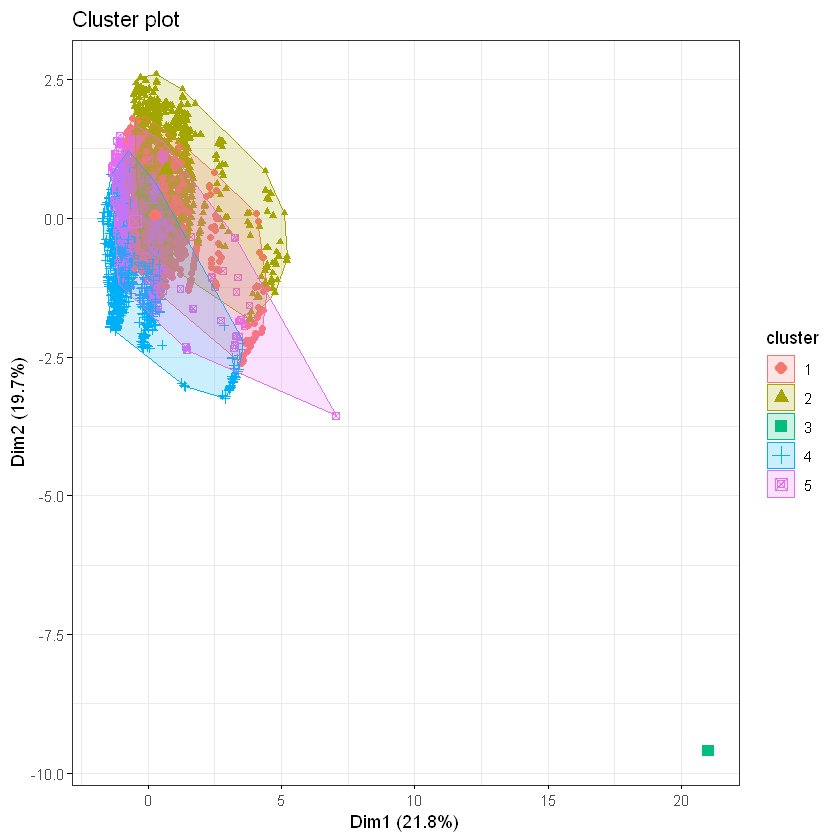

In [6]:
fviz_cluster(K, data = Anom, geom = "point",
             ellipse.type = "convex", 
             ggtheme = theme_bw()
             )

In [7]:
table(K$cluster)


   1    2    3    4    5 
5076 6160    8 4938 4230 

In [8]:
data <- cbind(df, Cluster = K$cluster)

head(data)

UserName,SrcDevice,DstDevice,Authent.Type,Failure,DailyCount,Cluster
User341813,Comp948451,Comp915658,NetworkLogon,0,1,2
User341813,Comp948451,Comp915658,NetworkLogon,0,1,2
User341813,Comp948451,Comp915658,NetworkLogon,0,1,2
User341813,Comp948451,Comp915658,NetworkLogon,0,1,2
User341813,Comp948451,Comp915658,NetworkLogon,0,1,2
User341813,Comp948451,Comp915658,NetworkLogon,0,1,2


In [9]:
data[data$Cluster==3, ]

,UserName,SrcDevice,DstDevice,Authent.Type,Failure,DailyCount,Cluster
13024,AppService,EnterpriseAppServer,None,InteractiveLogon,1,17102,3
13117,AppService,EnterpriseAppServer,None,InteractiveLogon,1,17112,3
13218,AppService,EnterpriseAppServer,None,InteractiveLogon,1,17078,3
13219,AppService,EnterpriseAppServer,None,InteractiveLogon,1,17078,3
13340,AppService,EnterpriseAppServer,None,InteractiveLogon,1,17091,3
13395,AppService,EnterpriseAppServer,None,InteractiveLogon,1,17092,3
13438,AppService,EnterpriseAppServer,None,InteractiveLogon,1,17080,3
13663,AppService,EnterpriseAppServer,None,InteractiveLogon,1,17104,3


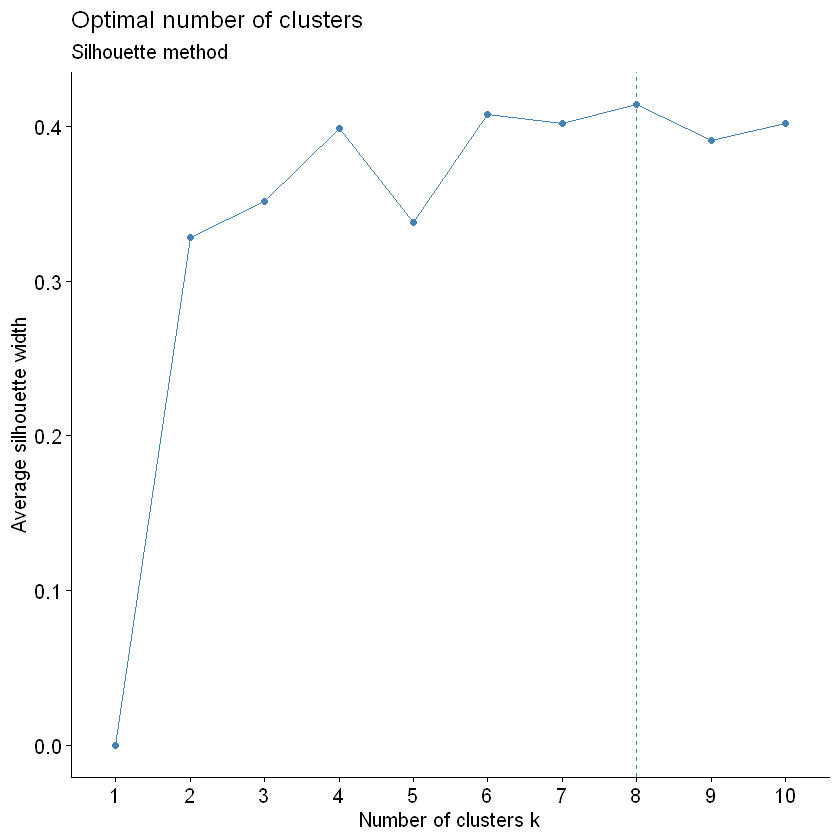

In [10]:
fviz_nbclust(Anom, FUNcluster=kmeans, method='silhouette') + labs(subtitle = "Silhouette method")
                    ## Gap static and elbow methods were also attempted, with poor results or no results at all.
                    ## Undocummented due to extensive computational length.

In [11]:
set.seed(123)
K2 <- kmeans(Anom, centers=5, nstart = 25, algorithm="Hartigan-Wong", iter.max = 10^4)
K3 <- kmeans(Anom, centers=5, nstart = 25, algorithm="MacQueen", iter.max = 10^4)

table(K2$cluster)
table(K3$cluster)
                ## Similar results to 'Lloyd'


   1    2    3    4    5 
5003 4165 5051    8 6185 


   1    2    3    4    5 
4165    8 5002 5072 6165 

In [23]:
set.seed(55)
options(warn=-1)
Km <- vector(len=50)
for(i in 1:50) {
    Km[i] <- kmeans(Anom, centers=5, nstart=i, algorithm="Lloyd", iter.max=10^4)
}

In [24]:
options(warn=1)

In [25]:
table(Km[50])
table(Km[1])
table(Km[25])


   1    2    3    4    5 
4176 5051    8 6174 5003 


   1    2    3    4    5 
2835 4814 3727 4243 4793 


   1    2    3    4    5 
6174    8 5051 4176 5003 

In [50]:
t1<- vector(len=50)
t2<- vector(len=50)
t3<- vector(len=50)
t4<- vector(len=50)
t5<- vector(len=50)
for(i in 1:50) {
    t1[i] <- as.vector(table(Km[i]))[1]
    t2[i] <- as.vector(table(Km[i]))[2]
    t3[i] <- as.vector(table(Km[i]))[3]
    t4[i] <- as.vector(table(Km[i]))[4]
    t5[i] <- as.vector(table(Km[i]))[5]
}

t1<- t1[order(t1, decreasing=FALSE)]
t2<- t2[order(t2, decreasing=FALSE)]
t3<- t3[order(t3, decreasing=FALSE)]
t4<- t4[order(t4, decreasing=FALSE)]
t5<- t5[order(t5, decreasing=FALSE)]

s1<- scale(t1)
s2<- scale(t2)
s3<- scale(t3)
s4<- scale(t4)
s5<- scale(t5)

In [53]:
manhattan_dist <- function(a, b){
     dist <- abs(a-b)
     dist <- sum(dist)
     return(dist)
}

In [56]:
manhattan_dist(s1, s2)
manhattan_dist(s1, s3)
manhattan_dist(s1, s4)
manhattan_dist(s1, s5)
cat("\n")
manhattan_dist(s2, s3)
manhattan_dist(s2, s4)
manhattan_dist(s2, s5)
cat("\n")
manhattan_dist(s3, s4)
manhattan_dist(s3, s5)
cat("\n")
manhattan_dist(s4, s5)

[1] 22.18659

[1] 22.07769

[1] 25.13818

[1] 17.99797

[1] 5.808436

[1] 6.608473

[1] 13.95672

[1] 9.62185

[1] 11.73321

[1] 17.01018

#### Setting up each of the 5 stages' properties

_Idea: All events start with a score of 0 to belong to StageN, N from 1 to 5. They get assigned +0.25, +0.5, +1 or +2 based on certain properties. This happens for all 5 stages, at which point they get shifted by a +5% of the total for each event (to avoid probabilities of 0) and numbers get transformed to probabilities (0 to 1). These 5 become features for clustering afterwards._

In [4]:
DecisionScoring <- function(df=df) {

Reconnaissance <- as.vector(rep(0, times=nrow(df)))
Delivery <- Reconnaissance
LateralMovement <- Delivery
PrivilegeEscalation <- LateralMovement
Exfiltration <- PrivilegeEscalation

for(i in 1:nrow(df)) {
    
    
    User <- df[i,]$UserName
    Src <- df[i,]$SrcDevice
    Dst <- df[i,]$DstDevice
    AT <- df[i,]$Authent.Type
    FA <- df[i,]$Failure
    
        # Reconnaissance[i] <- Reconnaissance[i] + 0
        # Delivery[i] <- Delivery[i] + 0
        # LateralMovement[i] <- LateralMovement[i] + 0
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        # Exfiltration[i] <- Exfiltration[i] + 0
    
    SourceFrequency <- df[df$SrcDevice==Src, ]
    UserFrequency <- df[df$UserName==User, ]
    UserAndSourceFrequency <- UserFrequency[UserFrequency$SrcDevice==Src, ]
    DestinationFrequency <- df[df$DstDevice==Dst, ]
    
    NSF <- nrow(SourceFrequency)
    t<- table(df$SrcDevice)
    M<- mean(t)
    S<- sd(t)
    if(NSF>= M + 2*S) {
        Reconnaissance[i] <- Reconnaissance[i] + 1.75
        Delivery[i] <- Delivery[i] + 0.5
        # LateralMovement[i] <- LateralMovement[i] + 0
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        # Exfiltration[i] <- Exfiltration[i] + 0
    }
     if(NSF/nrow(df)>=M+S & NSF/nrow(df)<M+2*S) {
        Reconnaissance[i] <- Reconnaissance[i] + 1.5
        Delivery[i] <- Delivery[i] + 0.75
        # LateralMovement[i] <- LateralMovement[i] + 0
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        # Exfiltration[i] <- Exfiltration[i] + 0
    }
     if(NSF/nrow(df)>=M & NSF/nrow(df)<M+S) {
        Reconnaissance[i] <- Reconnaissance[i] + 1.25
        Delivery[i] <- Delivery[i] + 0.75
        # LateralMovement[i] <- LateralMovement[i] + 0
        if(User%in%Special==TRUE) {
            PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0.25
            }
        # Exfiltration[i] <- Exfiltration[i] + 0
    }
     if(NSF/nrow(df)>=M/6 & NSF/nrow(df)<M) {
        Reconnaissance[i] <- Reconnaissance[i] + 0.25
        Delivery[i] <- Delivery[i] + 0.5
        # LateralMovement[i] <- LateralMovement[i] + 0
        if(User%in%Special==TRUE) {
            PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0.25
            }
        Exfiltration[i] <- Exfiltration[i] + 0.25
    }
     if(NSF/nrow(df)<M/6) {
        # Reconnaissance[i] <- Reconnaissance[i] + 0
        Delivery[i] <- Delivery[i] + 0.25
        LateralMovement[i] <- LateralMovement[i] + 0.75
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0.75
        Exfiltration[i] <- Exfiltration[i] + 0.25
    }
     L <- length(unique(SourceFrequency$UserName))
     if(L>=12) {
        # Reconnaissance[i] <- Reconnaissance[i] + 0
        # Delivery[i] <- Delivery[i] + 0
        # LateralMovement[i] <- LateralMovement[i] + 0
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 1
        Exfiltration[i] <- Exfiltration[i] + 0.5
         }
     if(L>=9 & L<12) {
        # Reconnaissance[i] <- Reconnaissance[i] + 0
        # Delivery[i] <- Delivery[i] + 0
        # LateralMovement[i] <- LateralMovement[i] + 0
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0.75
        Exfiltration[i] <- Exfiltration[i] + 0.25 
     }
     if(L>=5 & L<9) {
        # Reconnaissance[i] <- Reconnaissance[i] + 0
        # Delivery[i] <- Delivery[i] + 0
        # LateralMovement[i] <- LateralMovement[i] + 0
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0.5
        Exfiltration[i] <- Exfiltration[i] + 0.25
     }
     if(L>=2 & L<5) {
        # Reconnaissance[i] <- Reconnaissance[i] + 0
        Delivery[i] <- Delivery[i] + 0.25
        LateralMovement[i] <- LateralMovement[i] + 0.25
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        # Exfiltration[i] <- Exfiltration[i] + 0
     }
    if(L==1) {
        # Reconnaissance[i] <- Reconnaissance[i] + 0
        # Delivery[i] <- Delivery[i] + 0
        LateralMovement[i] <- LateralMovement[i] + 0.5
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        # Exfiltration[i] <- Exfiltration[i] + 0
    }
    if(User%in%Special==TRUE) {
        # Reconnaissance[i] <- Reconnaissance[i] + 0
        # Delivery[i] <- Delivery[i] + 0
        LateralMovement[i] <- LateralMovement[i] + 0.5
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 1
        Exfiltration[i] <- Exfiltration[i] + 1.5 
    }
    if(User%in%Special==FALSE) {
        Reconnaissance[i] <- Reconnaissance[i] + 1
        Delivery[i] <- Delivery[i] + 1
        LateralMovement[i] <- LateralMovement[i] + 0.5
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0.25
        # Exfiltration[i] <- Exfiltration[i] + 0
    }

    L <- length(unique(UserAndSourceFrequency$DstDevice))
    l <- length(unique(df$DstDevice))
    if(L/l>=0.4) {
        Reconnaissance[i] <- Reconnaissance[i] + 2
        # Delivery[i] <- Delivery[i] + 0
        # LateralMovement[i] <- LateralMovement[i] + 0
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        # Exfiltration[i] <- Exfiltration[i] + 0 
    }
    if(L/l>=0.2 & L/l<0.4) {
        Reconnaissance[i] <- Reconnaissance[i] + 1.75
        # Delivery[i] <- Delivery[i] + 0
        # LateralMovement[i] <- LateralMovement[i] + 0
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        # Exfiltration[i] <- Exfiltration[i] + 0
    }
    if(L/l>=0.1 & L/l<0.2) {
        Reconnaissance[i] <- Reconnaissance[i] + 1.5
        # Delivery[i] <- Delivery[i] + 0
        # LateralMovement[i] <- LateralMovement[i] + 0
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        # Exfiltration[i] <- Exfiltration[i] + 0
    }
    if(L/l>=0.05 & L/l<0.1) {
        Reconnaissance[i] <- Reconnaissance[i] + 1.25
        Delivery[i] <- Delivery[i] + 0.25
        # LateralMovement[i] <- LateralMovement[i] + 0
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        # Exfiltration[i] <- Exfiltration[i] + 0
    }
    if(L>=11 & L<34) {
        Reconnaissance[i] <- Reconnaissance[i] + 1
        Delivery[i] <- Delivery[i] + 0.5
        # LateralMovement[i] <- LateralMovement[i] + 0
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        # Exfiltration[i] <- Exfiltration[i] + 0
    }
    if(L>=6 & L<11) {
        Reconnaissance[i] <- Reconnaissance[i] + 0.5
        Delivery[i] <- Delivery[i] + 0.75
        LateralMovement[i] <- LateralMovement[i] + 0.25
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0.25
        Exfiltration[i] <- Exfiltration[i] + 0.25
    }
    if(L>=3 & L<6) {
        Reconnaissance[i] <- Reconnaissance[i] + 0.25
        Delivery[i] <- Delivery[i] + 0.75
        LateralMovement[i] <- LateralMovement[i] + 0.5
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0.75
        Exfiltration[i] <- Exfiltration[i] + 0.5
    }
    if(L<=2) {
        # Reconnaissance[i] <- Reconnaissance[i] + 0
        Delivery[i] <- Delivery[i] + 0.25
        LateralMovement[i] <- LateralMovement[i] + 0.75
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 1
        Exfiltration[i] <- Exfiltration[i] + 0.75
    }
    Destinations <- unique(UserFrequency$DstDevice)
    if(Src%in%Destinations==TRUE){
        # Reconnaissance[i] <- Reconnaissance[i] + 0
        # Delivery[i] <- Delivery[i] + 0
        LateralMovement[i] <- LateralMovement[i] + 3
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 1.25
        # Exfiltration[i] <- Exfiltration[i] + 0
    }
    
    D<- table(df$DstDevice)
    M<- mean(D)
    S<- sd(D)
    N<- nrow(df[df$DstDevice==Dst, ])
    if(N>=M+2*S){
        Reconnaissance[i] <- Reconnaissance[i] + 1.25
        # Delivery[i] <- Delivery[i] + 0
        # LateralMovement[i] <- LateralMovement[i] + 0
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        if(User%in%Special==TRUE) {
            Exfiltration[i] <- Exfiltration[i] + 1.5  
        }
        if(User%in%Special==FALSE) {
            Exfiltration[i] <- Exfiltration[i] + 0.5  
        }
    }
    if(N>=M+S & N<M+2*S) {
        Reconnaissance[i] <- Reconnaissance[i] + 1
        # Delivery[i] <- Delivery[i] + 0
        LateralMovement[i] <- LateralMovement[i] + 0.25
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        if(User%in%Special==TRUE) {
            Exfiltration[i] <- Exfiltration[i] + 1.5  
        }
        if(User%in%Special==FALSE) {
            Exfiltration[i] <- Exfiltration[i] + 0.25  
        }
    }
    if(N>=M & N<M+S) {
        Reconnaissance[i] <- Reconnaissance[i] + 0.75
        Delivery[i] <- Delivery[i] + 0.25
        LateralMovement[i] <- LateralMovement[i] + 0.25
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        if(User%in%Special==TRUE) {
            Exfiltration[i] <- Exfiltration[i] + 0.75  
        }
        if(User%in%Special==FALSE) {
            Exfiltration[i] <- Exfiltration[i] + 0.25  
        }
    }
    if(N>=M/4 & N<M) {
        Reconnaissance[i] <- Reconnaissance[i] + 0.5
        Delivery[i] <- Delivery[i] + 0.75
        LateralMovement[i] <- LateralMovement[i] + 0.25
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        # Exfiltration[i] <- Exfiltration[i] + 0
    }
    if(N>=4 & N<M/4) {
        Reconnaissance[i] <- Reconnaissance[i] + 0.25
        Delivery[i] <- Delivery[i] + 1
        LateralMovement[i] <- LateralMovement[i] + 0.5
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        # Exfiltration[i] <- Exfiltration[i] + 0
    }
    if(N<4) {
        # Reconnaissance[i] <- Reconnaissance[i] + 0
        Delivery[i] <- Delivery[i] + 0.75
        LateralMovement[i] <- LateralMovement[i] + 0.25
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        # Exfiltration[i] <- Exfiltration[i] + 0
    }
    
    U<- length(unique(DestinationFrequency$UserName))
    L<- length(unique(df$UserName))
    if(U>=L/5) {
        Reconnaissance[i] <- Reconnaissance[i] + 1
        # Delivery[i] <- Delivery[i] + 0
        # LateralMovement[i] <- LateralMovement[i] + 0
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        if(User%in%Special==TRUE) {
            Exfiltration[i] <- Exfiltration[i] + 0.5
        }
    }
    if(U>=L/10 & U<L/5) {
        Reconnaissance[i] <- Reconnaissance[i] + 0.75
        Delivery[i] <- Delivery[i] + 0.25
        # LateralMovement[i] <- LateralMovement[i] + 0
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        if(User%in%Special==TRUE) {
            Exfiltration[i] <- Exfiltration[i] + 0.5
        }
    }
    if(U>=L/20 & U<L/10) {
        Reconnaissance[i] <- Reconnaissance[i] + 0.5
        Delivery[i] <- Delivery[i] + 0.25
        # LateralMovement[i] <- LateralMovement[i] + 0
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        if(User%in%Special==TRUE) {
            Exfiltration[i] <- Exfiltration[i] + 0.75
        }
    }
    if(U<L/20) {
        Reconnaissance[i] <- Reconnaissance[i] + 0.25
        # Delivery[i] <- Delivery[i] + 0
        # LateralMovement[i] <- LateralMovement[i] + 0
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        if(User%in%Special==TRUE) {
            Exfiltration[i] <- Exfiltration[i] + 1.25
        }
    }
    
    S<- length(unique(DestinationFrequency$SrcDevice))
    L<- length(unique(df$SrcDevice))
    if(S/L>=0.2) {
        Reconnaissance[i] <- Reconnaissance[i] + 1.75
        # Delivery[i] <- Delivery[i] + 0
        LateralMovement[i] <- LateralMovement[i] + 0.75
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        Exfiltration[i] <- Exfiltration[i] + 0.5 
    }
    if(S/L>=0.1 & S/L<0.2) {
        Reconnaissance[i] <- Reconnaissance[i] + 1.25
        # Delivery[i] <- Delivery[i] + 0
        LateralMovement[i] <- LateralMovement[i] + 0.5
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        Exfiltration[i] <- Exfiltration[i] + 0.25
    }
    if(S/L>=0.05 & S/L<0.1) {
        Reconnaissance[i] <- Reconnaissance[i] + 1
        # Delivery[i] <- Delivery[i] + 0
        LateralMovement[i] <- LateralMovement[i] + 0.25
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        Exfiltration[i] <- Exfiltration[i] + 0.25
    }
    if(S>=24 & S<47) {
        Reconnaissance[i] <- Reconnaissance[i] + 0.75
        # Delivery[i] <- Delivery[i] + 0
        LateralMovement[i] <- LateralMovement[i] + 0.25
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        Exfiltration[i] <- Exfiltration[i] + 0.25
     }
    if(S>=5 & S<24) {
        Reconnaissance[i] <- Reconnaissance[i] + 0.5
        Delivery[i] <- Delivery[i] + 0.25
        LateralMovement[i] <- LateralMovement[i] + 0.25
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        Exfiltration[i] <- Exfiltration[i] + 0.25
    }
    if(S>=2 & S<5) {
        # Reconnaissance[i] <- Reconnaissance[i] + 0
        Delivery[i] <- Delivery[i] + 0.5
        # LateralMovement[i] <- LateralMovement[i] + 0
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0.25
        Exfiltration[i] <- Exfiltration[i] + 0.5
    }
    if(S==1) {
        # Reconnaissance[i] <- Reconnaissance[i] + 0
        Delivery[i] <- Delivery[i] + 1.25
        # LateralMovement[i] <- LateralMovement[i] + 0
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        Exfiltration[i] <- Exfiltration[i] + 0.25
    }
    
    Identical <- UserAndSourceFrequency[UserAndSourceFrequency$DstDevice==Dst, ]
    I <- nrow(Identical)
    if(I>12) {
        Reconnaissance[i] <- Reconnaissance[i] + 1.25
        Delivery[i] <- Delivery[i] + 0.25
        # LateralMovement[i] <- LateralMovement[i] + 0
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        # Exfiltration[i] <- Exfiltration[i] + 0
    }
    if(I>9 & I<=12) {
        Reconnaissance[i] <- Reconnaissance[i] + 0.75
        Delivery[i] <- Delivery[i] + 0.25
        # LateralMovement[i] <- LateralMovement[i] + 0
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0.25
        # Exfiltration[i] <- Exfiltration[i] + 0
    }
    if(I>6 & I<=9) {
        Reconnaissance[i] <- Reconnaissance[i] + 0.5
        Delivery[i] <- Delivery[i] + 0.5
        LateralMovement[i] <- LateralMovement[i] + 0.25
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0.25
        Exfiltration[i] <- Exfiltration[i] + 0.25
    }
    if(I>3 & I<=6) {
        Reconnaissance[i] <- Reconnaissance[i] + 0.5
        Delivery[i] <- Delivery[i] + 0.5
        LateralMovement[i] <- LateralMovement[i] + 0.25
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0.25
        Exfiltration[i] <- Exfiltration[i] + 0.25
    }
    if(I>1 & I<=3) {
        if(sum(Identical$Failure)==nrow(Identical)) {
            Reconnaissance[i] <- Reconnaissance[i] + 0.25
            }
        Delivery[i] <- Delivery[i] + 0.5
        LateralMovement[i] <- LateralMovement[i] + 0.5
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0.25
        Exfiltration[i] <- Exfiltration[i] + 0.5
    }
    if(I==1) {
        if(Identical$Failure==1) {
            Reconnaissance[i] <- Reconnaissance[i] + 0.25
        }
        Delivery[i] <- Delivery[i] + 1.25
        LateralMovement[i] <- LateralMovement[i] + 0.5
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0.25
        Exfiltration[i] <- Exfiltration[i] + 0.75
    }
    
    A<- length(unique(UserAndSourceFrequency$Authent.Type))
    if(A>3) {
        Reconnaissance[i] <- Reconnaissance[i] + 1.25
        Delivery[i] <- Delivery[i] + 1.5
        # LateralMovement[i] <- LateralMovement[i] + 0
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0.25
        # Exfiltration[i] <- Exfiltration[i] + 0  
    }
    if(A==3) {
        Reconnaissance[i] <- Reconnaissance[i] + 1
        Delivery[i] <- Delivery[i] + 1.25
        LateralMovement[i] <- LateralMovement[i] + 0.25
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0.5
        Exfiltration[i] <- Exfiltration[i] + 0.25
    }
    if(A==2) {
        Reconnaissance[i] <- Reconnaissance[i] + 0.75
        Delivery[i] <- Delivery[i] + 1
        LateralMovement[i] <- LateralMovement[i] + 1
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0.5
        Exfiltration[i] <- Exfiltration[i] + 1
    }
    if(A==1) {
        Reconnaissance[i] <- Reconnaissance[i] + 0.25
        Delivery[i] <- Delivery[i] + 0.5
        LateralMovement[i] <- LateralMovement[i] + 1.25
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0.5
        Exfiltration[i] <- Exfiltration[i] + 1.25
    }
    
    Identical <- Identical[Identical$Authent.Type==AT, ]
    I <- nrow(Identical)
    if(I>=2) {
        Reconnaissance[i] <- Reconnaissance[i] + 2
        Delivery[i] <- Delivery[i] + 1
        LateralMovement[i] <- LateralMovement[i] + 0.25
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0.25
        Exfiltration[i] <- Exfiltration[i] + 0.25  
    }
    if(I==1) {
        # Reconnaissance[i] <- Reconnaissance[i] + 0
        Delivery[i] <- Delivery[i] + 0.5
        LateralMovement[i] <- LateralMovement[i] + 1
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0.75
        Exfiltration[i] <- Exfiltration[i] + 1
    }
    
    Identical <- UserAndSourceFrequency[UserAndSourceFrequency$DstDevice==Dst, ]
    AuthTypes <- length(unique(Identical$Authent.Types))
    if(AuthTypes>=2) {
        Reconnaissance[i] <- Reconnaissance[i] + 1.75
        Delivery[i] <- Delivery[i] + 1.25
        LateralMovement[i] <- LateralMovement[i] + 1.25
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0.5
        # Exfiltration[i] <- Exfiltration[i] + 0
    }
    if(AuthTypes==1) {
        # Reconnaissance[i] <- Reconnaissance[i] + 0
        Delivery[i] <- Delivery[i] + 0.25
        LateralMovement[i] <- LateralMovement[i] + 0.25
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0.5
        # Exfiltration[i] <- Exfiltration[i] + 0
    }
    
    if(FA==1) {
        Reconnaissance[i] <- Reconnaissance[i] + 2
        Delivery[i] <- Delivery[i] + 1.5
        LateralMovement[i] <- LateralMovement[i] + 0.75
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0.25
        # Exfiltration[i] <- Exfiltration[i] + 0 
    }
    if(FA==0) {
        # Reconnaissance[i] <- Reconnaissance[i] + 0
        Delivery[i] <- Delivery[i] + 0.25
        LateralMovement[i] <- LateralMovement[i] + 0.5
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 1.5
        Exfiltration[i] <- Exfiltration[i] + 2
    }
    
    OF <- sum(UserAndSourceFrequency$Failure)
    SF <- nrow(UserAndSourceFrequency)
    if(OF/SF>=0.8) {
        Reconnaissance[i] <- Reconnaissance[i] + 2
        Delivery[i] <- Delivery[i] + 0.25
        # LateralMovement[i] <- LateralMovement[i] + 0
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        # Exfiltration[i] <- Exfiltration[i] + 0
    }
    if(OF/SF>=0.5 & OF/SF<0.8) {
        Reconnaissance[i] <- Reconnaissance[i] + 1.75
        Delivery[i] <- Delivery[i] + 0.5
        # LateralMovement[i] <- LateralMovement[i] + 0
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        # Exfiltration[i] <- Exfiltration[i] + 0
    }
    if(OF/SF>=0.2 & OF/SF<0.5) {
        Reconnaissance[i] <- Reconnaissance[i] + 1.25
        Delivery[i] <- Delivery[i] + 1
        LateralMovement[i] <- LateralMovement[i] + 0.5
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        # Exfiltration[i] <- Exfiltration[i] + 0
    }
    if(OF/SF>=0.1 & OF/SF<0.2) {
        Reconnaissance[i] <- Reconnaissance[i] + 0.5
        Delivery[i] <- Delivery[i] + 1.25
        LateralMovement[i] <- LateralMovement[i] + 0.75
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        # Exfiltration[i] <- Exfiltration[i] + 0
    }
    if(OF/SF>=0.02 & OF/SF<0.1) {
        Reconnaissance[i] <- Reconnaissance[i] + 0.25
        Delivery[i] <- Delivery[i] + 1
        LateralMovement[i] <- LateralMovement[i] + 0.5
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0.5
        Exfiltration[i] <- Exfiltration[i] + 0.25
    }
    if(OF/SF<0.02) {
        # Reconnaissance[i] <- Reconnaissance[i] + 0
        Delivery[i] <- Delivery[i] + 0.5
        LateralMovement[i] <- LateralMovement[i] + 0.25
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 1.5
        Exfiltration[i] <- Exfiltration[i] + 2
    }
    
    Identical <- Identical[Identical$Authent.Type==AT, ]
    FI <- length(unique(Identical$Failure))
    if(FI>=2) {
        Reconnaissance[i] <- Reconnaissance[i] + 0.5
        Delivery[i] <- Delivery[i] + 0.25
        LateralMovement[i] <- LateralMovement[i] + 0.5
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        # Exfiltration[i] <- Exfiltration[i] + 0
    }
    if(FI==1) {
        Reconnaissance[i] <- Reconnaissance[i] + 0.25
        Delivery[i] <- Delivery[i] + 0.75
        LateralMovement[i] <- LateralMovement[i] + 0.5
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 1.75
        Exfiltration[i] <- Exfiltration[i] + 2
    }
    
    if(AT=='TGT') {
        # Reconnaissance[i] <- Reconnaissance[i] + 0
        Delivery[i] <- Delivery[i] + 0.75
        LateralMovement[i] <- LateralMovement[i] + 0.5
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 1.5
        Exfiltration[i] <- Exfiltration[i] + 1.75
    }
    if(AT=='TGS') {
        # Reconnaissance[i] <- Reconnaissance[i] + 0
        Delivery[i] <- Delivery[i] + 1
        LateralMovement[i] <- LateralMovement[i] + 0.5
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 1.5
        Exfiltration[i] <- Exfiltration[i] + 1.75
    }
    if(AT=='InteractiveLogon' | AT=='RemoteInteractive') {
        Reconnaissance[i] <- Reconnaissance[i] + 1.5
        Delivery[i] <- Delivery[i] + 0.25
        LateralMovement[i] <- LateralMovement[i] + 1
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0.25
        # Exfiltration[i] <- Exfiltration[i] + 0 
    }
    if(AT=='NetworkLogon') {
        Reconnaissance[i] <- Reconnaissance[i] + 1.75
        Delivery[i] <- Delivery[i] + 0.25
        LateralMovement[i] <- LateralMovement[i] + 0.5
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0.25
        # Exfiltration[i] <- Exfiltration[i] + 0 
    }
    if(AT=='Batch') {
        # Reconnaissance[i] <- Reconnaissance[i] + 0
        Delivery[i] <- Delivery[i] + 1.5
        LateralMovement[i] <- LateralMovement[i] + 0.25
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0.5
        Exfiltration[i] <- Exfiltration[i] + 1.25 
    }
    if(AT=='Service') {
        # Reconnaissance[i] <- Reconnaissance[i] + 0
        Delivery[i] <- Delivery[i] + 1.5
        LateralMovement[i] <- LateralMovement[i] + 0.5
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 1.75
        Exfiltration[i] <- Exfiltration[i] + 1.25 
    }
    if(AT=='WorkstationLock') {
        # Reconnaissance[i] <- Reconnaissance[i] + 0
        Delivery[i] <- Delivery[i] + 0.75
        # LateralMovement[i] <- LateralMovement[i] + 0
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0.25
        Exfiltration[i] <- Exfiltration[i] + 2 
    }
    if(AT=='WorkstationUnlock') {
        Reconnaissance[i] <- Reconnaissance[i] + 0.75
        Delivery[i] <- Delivery[i] + 0.25
        LateralMovement[i] <- LateralMovement[i] + 0.25
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 1
        Exfiltration[i] <- Exfiltration[i] + 0.25 
    }
    if(AT=='ScreensaverInvoked') {
        # Reconnaissance[i] <- Reconnaissance[i] + 0
        Delivery[i] <- Delivery[i] + 0.75
        # LateralMovement[i] <- LateralMovement[i] + 0
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        # Exfiltration[i] <- Exfiltration[i] + 0
    }
    if(AT=='ScreensaverDismissed') {
        # Reconnaissance[i] <- Reconnaissance[i] + 0
        Delivery[i] <- Delivery[i] + 0.5
        LateralMovement[i] <- LateralMovement[i] + 0.25
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        # Exfiltration[i] <- Exfiltration[i] + 0
    }
    if(AT=='CachedInteractive') {
        Reconnaissance[i] <- Reconnaissance[i] + 0.75
        Delivery[i] <- Delivery[i] + 0.5
        LateralMovement[i] <- LateralMovement[i] + 0.25
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0.25
        # Exfiltration[i] <- Exfiltration[i] + 0
    }
    progress(i)
    # Sys.sleep(0.01)
}
  Stages <<- as.data.frame(cbind(Reconnaissance, Delivery, LateralMovement, PrivilegeEscalation, Exfiltration))
    }

In [5]:
StagesIntegrityTest <- function() {
    c<- 0
    for(i in 1:nrow(Stages)) {
        S <- sum(Stages[i, ])
        MaxMin <- max(Stages[i, ]) - min(Stages[i, ])
        if(MaxMin <= S/10) {
            c <- c+1
        }
    }
    print(paste("The integrity of Stages is", c/nrow(Stages)))
}

### Actual anomalies

In [6]:
setwd("D://LA//ATI Data")
df <- read.table(file="FinalAnomalies.txt", header=T, sep=",")
df<- df[,-1]

df %>% mutate(across(where(is.factor), as.character)) -> df

str(df)
head(df,10)
dim(df)

'data.frame':	38712 obs. of  8 variables:
 $ UserName    : chr  "User735240" "User735240" "User735240" "User735240" ...
 $ SrcDevice   : chr  "Comp700191" "Comp700191" "Comp738078" "Comp700191" ...
 $ DstDevice   : chr  "Comp774964" "Comp700191" "ActiveDirectory" "ActiveDirectory" ...
 $ Authent.Type: chr  "NetworkLogon" "NetworkLogon" "TGT" "TGT" ...
 $ Failure     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ DailyCount  : num  3 1 1 1 2 1 1 1 1 18 ...
 $ Hour        : int  0 0 5 6 12 17 18 19 19 23 ...
 $ Day         : int  59 59 59 59 59 59 59 59 59 59 ...


UserName,SrcDevice,DstDevice,Authent.Type,Failure,DailyCount,Hour,Day
User735240,Comp700191,Comp774964,NetworkLogon,0,3,0,59
User735240,Comp700191,Comp700191,NetworkLogon,0,1,0,59
User735240,Comp738078,ActiveDirectory,TGT,0,1,5,59
User735240,Comp700191,ActiveDirectory,TGT,0,1,6,59
User735240,Comp738078,Comp700191,TGS,0,2,12,59
User735240,Comp738078,Comp700191,RemoteInteractive,0,1,17,59
User735240,Comp700191,Comp370444,TGS,0,1,18,59
User735240,Comp700191,Comp700191,TGS,0,1,19,59
User735240,Comp700191,Comp370444,NetworkLogon,0,1,19,59
User735240,Comp700191,ActiveDirectory,NetworkLogon,0,18,23,59


[1] 38712     8

In [7]:
df$Day <- df$Day + df$Hour/24
head(df)

UserName,SrcDevice,DstDevice,Authent.Type,Failure,DailyCount,Hour,Day
User735240,Comp700191,Comp774964,NetworkLogon,0,3,0,59.00000
User735240,Comp700191,Comp700191,NetworkLogon,0,1,0,59.00000
User735240,Comp738078,ActiveDirectory,TGT,0,1,5,59.20833
User735240,Comp700191,ActiveDirectory,TGT,0,1,6,59.25000
User735240,Comp738078,Comp700191,TGS,0,2,12,59.50000
User735240,Comp738078,Comp700191,RemoteInteractive,0,1,17,59.70833


In [8]:
df<- df[order(df$Day), ]
head(df, 20)

,UserName,SrcDevice,DstDevice,Authent.Type,Failure,DailyCount,Hour,Day
1079,User288751,Comp468329,Comp253429,TGS,0,1,0,58
1080,User288751,Comp468329,Comp370444,NetworkLogon,0,19,0,58
1081,User288751,Comp916004,Comp916004,TGS,0,16,0,58
1082,User288751,Comp468329,Comp797582,NetworkLogon,0,2,0,58
1649,User396223,Comp068848,ActiveDirectory,TGT,0,2,0,58
2765,User341813,Comp948451,Comp915658,NetworkLogon,0,4,0,58
2766,User341813,Comp107130,Comp916004,NetworkLogon,0,27,0,58
3358,User091297,Comp955934,Comp939275,NetworkLogon,0,2,0,58
3440,User379647,Comp416133,Comp370444,TGS,0,1,0,58
3441,User379647,Comp416133,ActiveDirectory,TGS,0,10,0,58


In [9]:
df<- df[,-c(6:8)]
head(df)

,UserName,SrcDevice,DstDevice,Authent.Type,Failure
1079,User288751,Comp468329,Comp253429,TGS,0
1080,User288751,Comp468329,Comp370444,NetworkLogon,0
1081,User288751,Comp916004,Comp916004,TGS,0
1082,User288751,Comp468329,Comp797582,NetworkLogon,0
1649,User396223,Comp068848,ActiveDirectory,TGT,0
2765,User341813,Comp948451,Comp915658,NetworkLogon,0


_At this stage we have our desired dataset_

In [10]:
g<- grep(pattern='User', x=df$UserName)
Special <- unique(df$UserName[-g])
g<- grep(pattern='Comp', x=Special)
Special <- Special[-g]
Special

[1] "winservice"    "AppService"    "Administrator"

In [11]:
DecisionScoring(df)

Progress:   1%Progress:   2%Progress:   3%Progress:   4%Progress:   5%Progress:   6%Progress:   7%Progress:   8%Progress:   9%Progress:  10%Progress:  11%Progress:  12%Progress:  13%Progress:  14%Progress:  15%Progress:  16%Progress:  17%Progress:  18%Progress:  19%Progress:  20%Progress:  21%Progress:  22%Progress:  23%Progress:  24%Progress:  25%Progress:  26%Progress:  27%Progress:  28%Progress:  29%Progress:  30%Progress:  31%Progress:  32%Progress:  33%Progress:  34%Progress:  35%Progress:  36%Progress:  37%Progress:  38%Progress:  39%Progress:  40%Progress:  41%Progress:  42%Progress:  43%Progress:  44%Progress:  45%Progress:  46%Progress:  47%Progress:  48%Progress:  49%Progress:  50%Progress:  51%Progress:  52%Progress:  53%Progress:  54%Progress:  55%Progress:  56%Progress:  57%Progress:  58%Progress:  59%Progress:  60%Progress:  61%Progress:  62%Progress:  63%Progress:  64%Progress:  65%Progress:  66%Progress:  67%Progress:  68%Progress:  69%Progress:  70%Progress:  71%Progre

In [12]:
head(Stages, 25)

Reconnaissance,Delivery,LateralMovement,PrivilegeEscalation,Exfiltration
8.00,7.50,7.75,9.25,9.25
12.50,6.25,7.50,7.75,7.50
10.25,7.00,7.50,11.25,10.50
8.75,7.50,7.00,8.25,7.00
10.25,7.00,7.75,9.25,9.50
14.00,7.25,7.50,6.75,5.50
11.25,5.50,5.50,8.75,9.75
11.25,7.25,5.00,6.00,5.50
6.75,6.75,9.25,10.25,11.00
6.75,6.75,9.25,10.25,11.00


In [13]:
StagesIntegrityTest()

[1] "The integrity of Stages is 0.326436247158504"


In [14]:
StageAssignExpect <- function() {
    R <- rowSums(Stages)
    Probs <- Stages/R
    Maximum <- pmax(Probs$Reconnaissance,Probs$Delivery,Probs$LateralMovement,Probs$PrivilegeEscalation,Probs$Exfiltration)
    Probs_with_clusters <- cbind(Probs, Maximum)
    
    Cluster <- vector(len=nrow(Probs_with_clusters))
for(i in 1:nrow(Probs_with_clusters)) {
    if(Probs_with_clusters$Maximum[i]==Probs_with_clusters$Reconnaissance[i]) {
        Cluster[i] <- "R"
    }
    if(Probs_with_clusters$Maximum[i]==Probs_with_clusters$Delivery[i]) {
        Cluster[i] <- "D"
    }
    if(Probs_with_clusters$Maximum[i]==Probs_with_clusters$LateralMovement[i]) {
        Cluster[i] <- "LM"
    }
    if(Probs_with_clusters$Maximum[i]==Probs_with_clusters$PrivilegeEscalation[i]) {
        Cluster[i] <- "PE"
    }
    if(Probs_with_clusters$Maximum[i]==Probs_with_clusters$Exfiltration[i]) {
        Cluster[i] <- "E"
    }
}

Probs_with_clusters <<- cbind(UserName = df$UserName, Probs_with_clusters, Cluster)

}

In [15]:
StageAssignExpect()

In [16]:
head(Probs_with_clusters, 15)

UserName,Reconnaissance,Delivery,LateralMovement,PrivilegeEscalation,Exfiltration,Maximum,Cluster
User288751,0.1916168,0.1796407,0.1856287,0.2215569,0.2215569,0.2215569,E
User288751,0.3012048,0.1506024,0.1807229,0.1867470,0.1807229,0.3012048,R
User288751,0.2204301,0.1505376,0.1612903,0.2419355,0.2258065,0.2419355,PE
User288751,0.2272727,0.1948052,0.1818182,0.2142857,0.1818182,0.2272727,R
User396223,0.2342857,0.1600000,0.1771429,0.2114286,0.2171429,0.2342857,R
User341813,0.3414634,0.1768293,0.1829268,0.1646341,0.1341463,0.3414634,R
User341813,0.2760736,0.1349693,0.1349693,0.2147239,0.2392638,0.2760736,R
User091297,0.3214286,0.2071429,0.1428571,0.1714286,0.1571429,0.3214286,R
User379647,0.1534091,0.1534091,0.2102273,0.2329545,0.2500000,0.2500000,E
User379647,0.1534091,0.1534091,0.2102273,0.2329545,0.2500000,0.2500000,E


In [17]:
T1 <- table(Probs_with_clusters$Cluster)
T1


    D     E    LM    PE     R 
  657  8421   414  2472 26748 

In [18]:
OldProbs <- Probs_with_clusters

In [ ]:
K1 <- kmeans(Stages, centers=5, nstart = sample(1:nrow(Stages), size=1), algorithm="Lloyd", iter.max = 10^4)
TK1 <- table(K1$cluster)
TK1

fviz_cluster(K1, data = Stages, geom = "point",
             ellipse.type = "convex", 
             ggtheme = theme_bw()
             )

#### Retrospective chronology: 2nd training phase

In [ ]:
PWC <- as.data.frame(cbind(UserName = Probs_with_clusters$UserName, Stages, Cluster = Probs_with_clusters$Cluster))
head(PWC, 5)

In [ ]:
L <- as.list(unique(Probs_with_clusters$UserName))
length(L)

In [ ]:
RedistributeWeight <- function() {
    df <- data.frame()
    for(User in L) {        
        data <- PWC[PWC$UserName==User, ]
        data$Reconnaissance[1] <- data$Reconnaissance[1] + 1.5
        data$Cluster[1] <- 'R'
        if(nrow(data)>=2) {
            M <- vector(len=nrow(data)-1)
            S <- vector(len=nrow(data)-1)
            for(i in 2:nrow(data)) {
                M[i-1] <- max(c(data$Reconnaissance[i-1], data$Delivery[i-1], data$LateralMovement[i-1], data$PrivilegeEscalation[i-1], data$Exfiltration[i-1]))
                S[i] <- sum(c(data[i,2], data[i,3], data[i,4], data[i,5], data[i,6]))
                F <- 1.1*(S[i]/10)
                if(M[i-1]==data$Reconnaissance[i-1]) {
                    data$Reconnaissance[i] <- data$Reconnaissance[i] + F
                    data$Delivery[i] <- data$Delivery[i] + F
                }
                if(M[i-1]==data$Delivery[i-1]) {
                    data$LateralMovement[i] <- data$LateralMovement[i] + F
                    data$Delivery[i] <- data$Delivery[i] + F
                }
                if(M[i-1]==data$LateralMovement[i-1]) {
                    data$LateralMovement[i] <- data$LateralMovement[i] + F
                    data$PrivilegeEscalation[i] <- data$PrivilegeEscalation[i] + F
                }
                if(M[i-1]==data$PrivilegeEscalation[i-1]) {
                    data$PrivilegeEscalation[i] <- data$PrivilegeEscalation[i] + F
                    data$Exfiltration[i] <- data$Exfiltration[i] + F
                }
                if(M[i-1]==data$Exfiltration[i-1]) {
                    data$Exfiltration[i] <- data$Exfiltration[i] + F
                }
            }
        }
        df <- as.data.frame(rbind(df, data))
    }
    UpdatedStages <<- df
}

In [ ]:
RedistributeWeight()

In [ ]:
head(UpdatedStages)

In [ ]:
US <- UpdatedStages[order(as.numeric(rownames(UpdatedStages)), decreasing=FALSE), ]

In [ ]:
Stages <- US[, -c(1,7)]

In [ ]:
head(Stages)

In [ ]:
StageAssignExpect()

In [ ]:
head(Probs_with_clusters, 10)

In [ ]:
T2 <- table(Probs_with_clusters$Cluster)
T2

In [ ]:
K1 <- kmeans(Stages, centers=5, nstart = sample(1:nrow(Stages), size=1), algorithm="Lloyd", iter.max = 10^4)
TK2 <- table(K1$cluster)
TK2

fviz_cluster(K1, data = Stages, geom = "point",
             ellipse.type = "convex", 
             ggtheme = theme_bw()
             )

In [ ]:
TF1 <- as.vector(T1)
TF2 <- as.vector(T2)

YK1 <- as.vector(TK1)
YK2 <- as.vector(TK2)

In [ ]:
manhattan_dist <- function(a, b){
     dist <- abs(a-b)
     dist <- sum(dist)
     return(dist)
}

min_max_norm <- function(x) {
    (x - min(x)) / (max(x) - min(x))
  }

In [ ]:
TFN1 <- min_max_norm(TF1)
TFN2 <- min_max_norm(TF2)
YKN1 <- min_max_norm(YK1)
YKN2 <- min_max_norm(YK2)

TFN1 <- TFN1[order(TFN1, decreasing=FALSE)]
TFN2 <- TFN2[order(TFN2, decreasing=FALSE)]
YKN1 <- YKN1[order(YKN1, decreasing=FALSE)]
YKN2 <- YKN2[order(YKN2, decreasing=FALSE)]

TFN1
TFN2
YKN1
YKN2

In [ ]:
manhattan_dist(TFN1, TFN2)
cat("\n")
print("Breakdown of stage dissimilarity across Stage classification before and after weight redistribution:")
cat("\n")
for(i in 1:length(TFN1)) {
    print(manhattan_dist(TFN1[i], TFN2[i]))
    cat("\n")
}

In [ ]:
manhattan_dist(YKN1, YKN2)
cat("\n")
print("Breakdown of stage dissimilarity across Cluster classification before and after weight redistribution:")
cat("\n")
for(i in 1:length(YKN1)) {
    print(manhattan_dist(YKN1[i], YKN2[i]))
    cat("\n")
}

In [ ]:
manhattan_dist(TFN1, YKN1)
cat("\n")
print("Breakdown of stage dissimilarity between Stage classification and Cluster classification, BEFORE redistribution:")
cat("\n")
for(i in 1:length(TFN1)) {
    print(manhattan_dist(TFN1[i], YKN1[i]))
    cat("\n")
}

In [ ]:
manhattan_dist(TFN2, YKN2)
cat("\n")
print("Breakdown of stage dissimilarity between Stage classification and Cluster classification, AFTER redistribution:")
cat("\n")
for(i in 1:length(TFN2)) {
    print(manhattan_dist(TFN2[i], YKN2[i]))
    cat("\n")
}

In [ ]:
Initial_And_Redistr_Stage <- manhattan_dist(TFN1, TFN2)
Initial_And_Redistr_Cluster <- manhattan_dist(YKN1, YKN2)
Initial_Stage_And_Cluster <- manhattan_dist(TFN1, YKN1)
Redistr_Stage_And_Cluster <- manhattan_dist(TFN2, YKN2)

Results <- as.data.frame(cbind(Results= c(Initial_And_Redistr_Stage, Initial_And_Redistr_Cluster, Initial_Stage_And_Cluster, Redistr_Stage_And_Cluster), 
                        Name = c("Initial_And_Redistr_Stage", "Initial_And_Redistr_Cluster", "Initial_Stage_And_Cluster", "Redistr_Stage_And_Cluster")))

Results

In [ ]:
Results %>% mutate(across(where(is.factor), as.character)) -> Results
Results[,1] <- as.numeric(Results[,1])

str(Results)

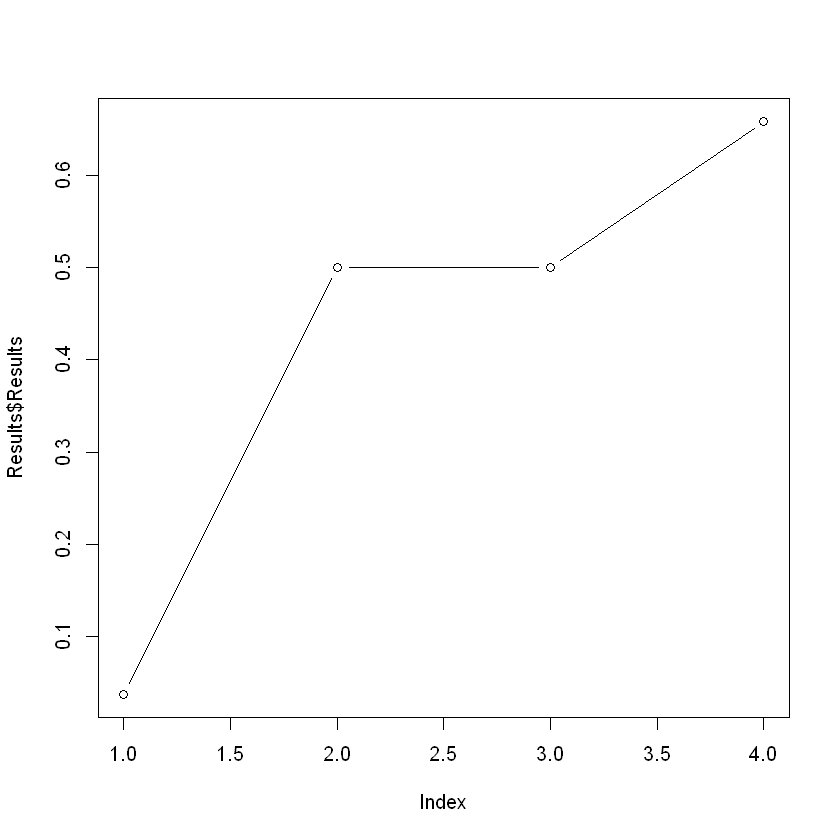

In [95]:
op <- par(mfrow=c(1,2))
barplot(c(Results[1,1], Results[2,1]), main="Algorithm results", 
        sub=cat("Effectiveness of results change before and after redistribution\nacross both Stage and Clustering"), 
       col=ifelse(x<mean(x), "red", "green"))
barplot(c(Results[3,1], Results[4,1]), main="Redistribution results", 
        sub=cat("Effectiveness of results change between Stage and Clustering\nfirst before redistribution, and then after"), 
       col=ifelse(x<mean(x), "red", "green"))
par(op)